# 19기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
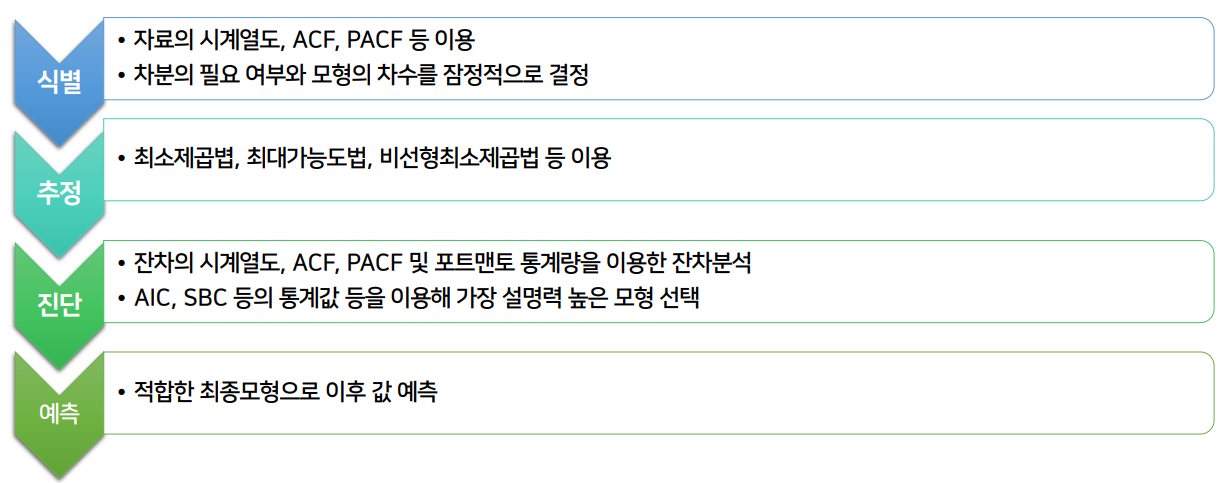

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

In [1]:
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 라이브러리 불러오기

In [2]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 

## 데이터 불러오기

## 식별

In [3]:
df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

df = df[["Close"]]

df = df.reset_index()

df.columns = ['day', 'price']

df['day'] = pd.to_datetime(df['day'])

df.index = df['day']
df.set_index('day', inplace=True)

df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


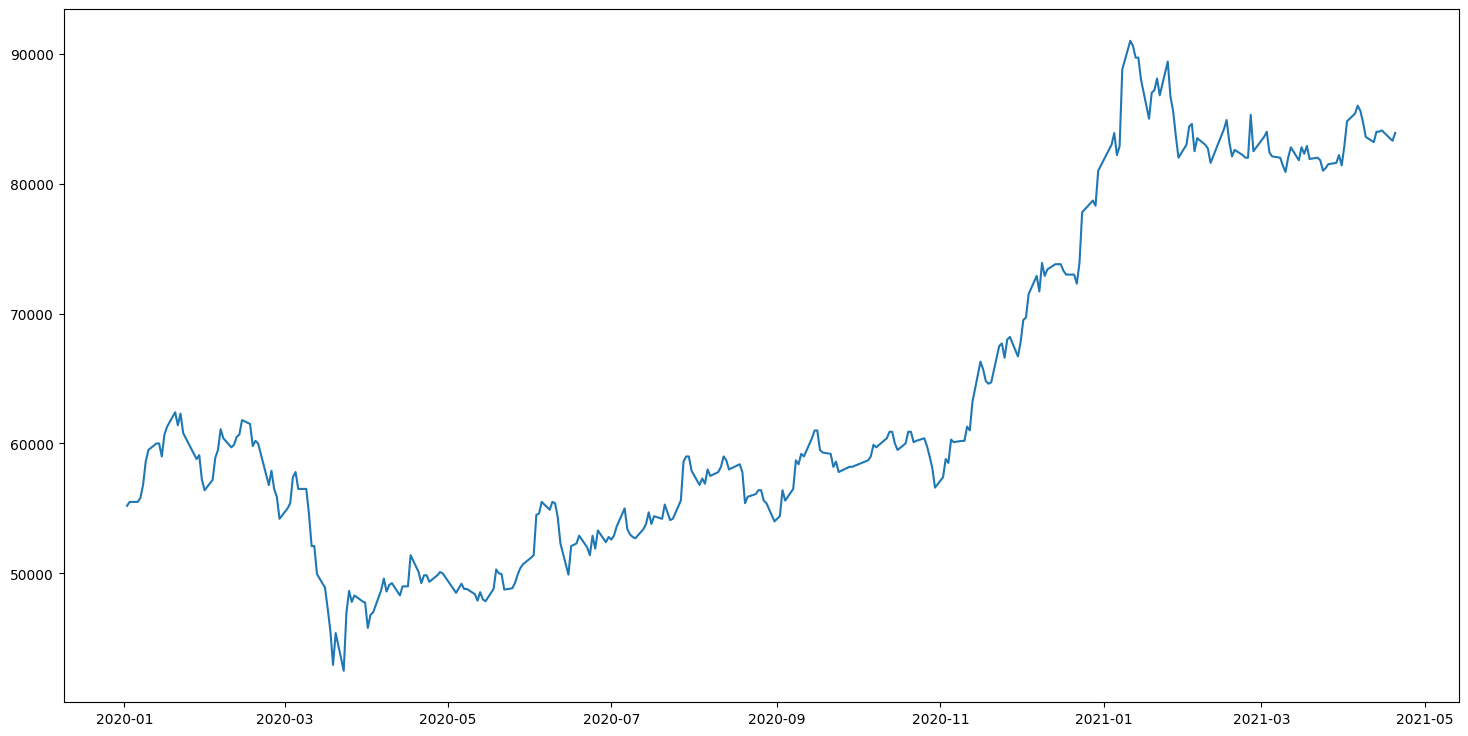

In [4]:
plt.figure(figsize=(18,9))
plt.plot(df.index, df['price'], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show()

In [5]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [6]:
train_data

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-03-29,81600.0
2021-03-30,82200.0
2021-03-31,81400.0


In [37]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df)
print(f'ADF statistics: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical values: ')
for key, value in result[4].items():
    print(f'\t{key}: {value}')


ADF statistics: -0.21218947966329235
p-value: 0.9370529809409828
Critical values: 
	1%: -3.450886958636161
	5%: -2.870586350823483
	10%: -2.5715897843576827


- p-value가 0.93으로 >>0.05여서 귀무가설이 채택될 가능성이 매우 높다. 즉, 안정성을 띠지 않을 가능성이 매우 높으므로 ARIMA의 파라미터를 조정하여 차분을 통해 정상화한다.

## 추정

In [10]:
# 반복문으로 가장 적절한 p, q값을 찾겠다.
# https://hongl.tistory.com/99 의 코드를 참고하였다.

import itertools

p = q = d = range(0, 3)
p1q = list(itertools.product(p, [1], q))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [11]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

aic_list = {}

for param in p1q:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(train_data['price'], order=param, seasonal_order=param_seasonal)
            res = tmp_mdl.fit()
            aic_list[(param, param_seasonal)] = res.aic
            print(f'SARIMAX{param}x{param_seasonal} - AIC {res.aic}')
            
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            continue

print(f'BEST SARIMAX{best_pdq}x{best_seasonal_pdq} - AIC {best_aic}')


SARIMAX(0, 1, 0)x(0, 0, 0, 12) - AIC 5281.705279536481
SARIMAX(0, 1, 0)x(0, 0, 1, 12) - AIC 5283.07656126528
SARIMAX(0, 1, 0)x(0, 0, 2, 12) - AIC 5286.282829618717
SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC 5283.379024759622
SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC 5240.755078826971
SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC 5223.695566612494
SARIMAX(0, 1, 0)x(0, 2, 0, 12) - AIC 5396.046785972646
SARIMAX(0, 1, 0)x(0, 2, 1, 12) - AIC 5108.296281242546
SARIMAX(0, 1, 0)x(0, 2, 2, 12) - AIC 5030.210616881909
SARIMAX(0, 1, 0)x(1, 0, 0, 12) - AIC 5282.96743021175
SARIMAX(0, 1, 0)x(1, 0, 1, 12) - AIC 5278.339552930861
SARIMAX(0, 1, 0)x(1, 0, 2, 12) - AIC 5281.019068509733
SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC 5254.801690522843
SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC 5219.239111303737
SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC 5221.038446437158
SARIMAX(0, 1, 0)x(1, 2, 0, 12) - AIC 5301.708881503796
SARIMAX(0, 1, 0)x(1, 2, 1, 12) - AIC 5038.650189367035
SARIMAX(0, 1, 0)x(1, 2, 2, 12) - AIC 5029.104016171237
SARIMAX(0, 1

In [12]:
sorted(aic_list.items(), key=lambda x: x[1])
#(1, 1, 1), (2, 2, 2, 12)는 제외.
#(0, 1, 0), (1, 2, 2, 12)가 best case.

[(((1, 1, 1), (2, 2, 2, 12)), 14.0),
 (((0, 1, 0), (1, 2, 2, 12)), 5029.104016171237),
 (((0, 1, 0), (2, 2, 2, 12)), 5029.246836377475),
 (((0, 1, 0), (0, 2, 2, 12)), 5030.210616881909),
 (((1, 1, 0), (1, 2, 2, 12)), 5030.935390802477),
 (((0, 1, 0), (2, 2, 1, 12)), 5031.084359026465),
 (((1, 1, 0), (0, 2, 2, 12)), 5031.809086433257),
 (((0, 1, 1), (0, 2, 2, 12)), 5031.829088110626),
 (((0, 1, 2), (1, 2, 2, 12)), 5031.909806082194),
 (((2, 1, 0), (1, 2, 2, 12)), 5031.921154691485),
 (((0, 1, 2), (0, 2, 2, 12)), 5031.958093005294),
 (((2, 1, 0), (0, 2, 2, 12)), 5032.1803403158165),
 (((0, 1, 2), (2, 2, 2, 12)), 5032.747972818686),
 (((1, 1, 0), (2, 2, 1, 12)), 5032.965847896872),
 (((0, 1, 1), (2, 2, 1, 12)), 5033.00406013608),
 (((1, 1, 2), (1, 2, 2, 12)), 5033.062150576341),
 (((0, 1, 2), (2, 2, 1, 12)), 5033.445440588728),
 (((2, 1, 0), (2, 2, 1, 12)), 5033.621774343072),
 (((2, 1, 1), (0, 2, 2, 12)), 5035.71014309487),
 (((1, 1, 2), (0, 2, 2, 12)), 5035.86342845983),
 (((1, 1, 2), (

## 예측

<AxesSubplot: xlabel='day'>

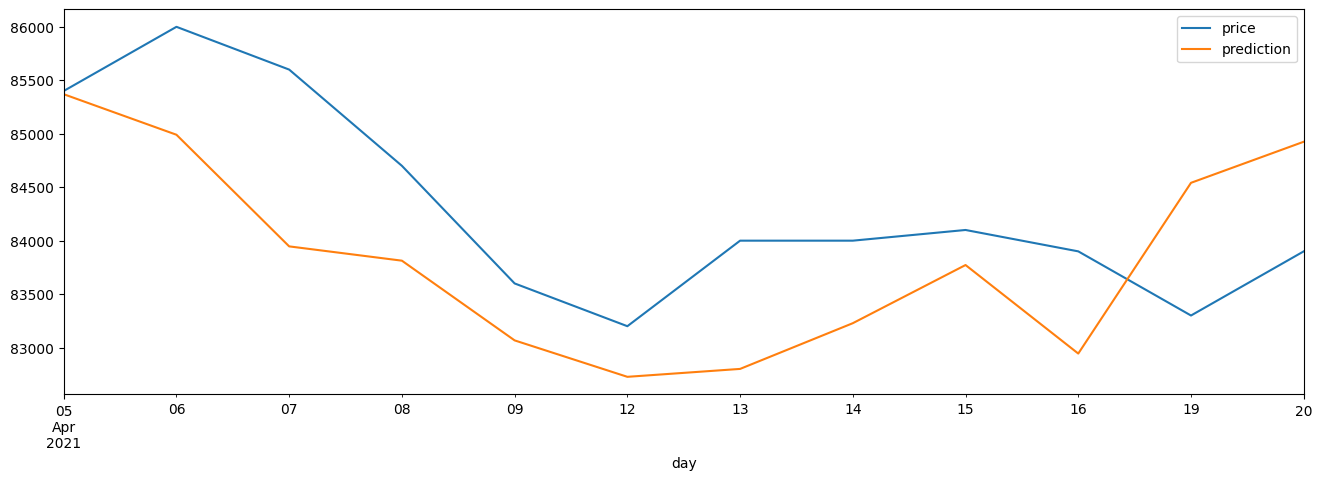

In [34]:
best_mdl = SARIMAX(train_data['price'], order=(0, 1, 0), seasonal_order=(1, 2, 2, 12))
best_res = best_mdl.fit()
            
arima_pred = best_res.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
test_data['prediction'] = np.array(arima_pred) 
test_data['price'].plot(figsize = (16,5), legend=True)
test_data['prediction'].plot(figsize = (16, 5), legend = True)

In [38]:
arima_rmse_error = rmse(test_data['price'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['price'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 891246.8914415867
RMSE Error: 944.0587330466186
Mean: 63323.60248447205


In [39]:
test_data['ARIMA_Predictions'] = arima_pred